In [1]:
# # comment out this part when run locally
# from google.colab import drive
# drive.mount('/gdrive')
# %cd /gdrive/My\ Drive/similar_faces/

In [2]:
import os
import glob
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision import models
from PIL import Image
%matplotlib inline

In [3]:
if torch.cuda.is_available():
    print(f'Cuda device: {torch.cuda.get_device_name(0)}')
else:
    print('Cuda unavailable')

Cuda unavailable


In [4]:
# Hyperparameters
num_epochs = 1
batch_size = 8
learning_rate = 0.00001

num_classes = 22
num_images_per_class = 10

## Dataset

In [5]:
class SimilarFaceDataset(Dataset):
    def __init__(self, num_classes, num_images_per_class, image_size=128):
        self.num_classes = num_classes
        self.num_images_per_class = num_images_per_class
        self.images = []
        
        transform = transforms.Compose([
            transforms.Resize((image_size, image_size)),
            transforms.ToTensor(),
            lambda image: image[:-1],
        ])
        
        for i in range(self.num_classes):
            pathname = os.path.join('data/', f'c{i+1}')
            tmp = []
            for filename in glob.glob(f'{pathname}/*'):
                tmp.append(transform(Image.open(filename)))
            self.images.append(tmp)
            
        self.triplets = []
        for positive_class in range(self.num_classes):
            for anchor in range(self.num_images_per_class):
                for positive in range(self.num_images_per_class):
                    if anchor != positive:
                        for negative_class in range(self.num_classes):
                            if negative_class != positive_class:
                                for negative in range(self.num_images_per_class):
                                    self.triplets.append([
                                        self.images[positive_class][anchor],
                                        self.images[positive_class][positive],
                                        self.images[negative_class][negative]
                                    ])
            
    def __len__(self):
        return len(self.triplets)
    
    def __getitem__(self, index):
        """Return a tuple (Anchor, Positive, Negative)"""
        return self.triplets[index]
    
dataset = SimilarFaceDataset(num_classes, num_images_per_class)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

## Siamese Network

In [6]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 32, 5),
            nn.PReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 5),
            nn.PReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 64, 5),
            nn.PReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 64, 5),
            nn.PReLU(),
            nn.MaxPool2d(2),
        )

        self.fc = nn.Sequential(
            nn.Linear(64 * 4 * 4, 256),
            nn.PReLU(),
            nn.Linear(256, 256),
            nn.PReLU(),
            nn.Linear(256, 2)
        )

    def forward_once(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x
        
    def forward(self, anchor, positive, negative):
        anchor_out = self.forward_once(anchor)
        positive_out = self.forward_once(positive)
        negative_out = self.forward_once(negative)
        return (anchor_out, positive_out, negative_out)

## Setup

In [35]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = SiameseNetwork().to(device)

# Loss and optimizer
criterion = torch.nn.TripletMarginLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

## Training

In [18]:
model.eval()
num_step_to_print_info = 100

test_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
test_iter = iter(test_loader)
accu_loss = 0
for i in range(num_step_to_print_info):
    anchors, positives, negatives = test_iter.next()
    anchors = anchors.to(device)
    positives = positives.to(device)
    negatives = negatives.to(device)
    anchor_outputs, positive_outputs, negative_outputs = model(anchors, positives, negatives)
    loss = criterion(anchor_outputs, positive_outputs, negative_outputs)
    accu_loss += loss.item()
print(f'Initial accu loss: {accu_loss}')

Initial accu loss: 2.1532261669635773


In [50]:
# Load checkpoint
checkpoint = torch.load('checkpoint', map_location=torch.device('cpu'))
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

In [11]:
# model.train()

# accu_loss = 0
# accu_loss_history = []

# total_step = len(data_loader)
# for epoch in range(num_epochs):
#     for step, (anchors, positives, negatives) in enumerate(data_loader):
#         anchors = anchors.to(device)
#         positives = positives.to(device)
#         negatives = negatives.to(device)
        
#         # forward pass
#         anchor_outputs, positive_outputs, negative_outputs = model(anchors, positives, negatives)
#         loss = criterion(anchor_outputs, positive_outputs, negative_outputs)
#         accu_loss += loss.item()
        
#         # backward pass
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()
        
#         if (step + 1) % num_step_to_print_info == 0:
#             print(f'Epoch [{epoch+1}/{num_epochs}], Step [{step+1}/{total_step}], Accu loss: {accu_loss:.4f}')
#             accu_loss_history.append(accu_loss)
#             accu_loss = 0

# plt.plot(accu_loss_history)

In [12]:
# # save checkpoint
# torch.save({
#             'model_state_dict': model.state_dict(),
#             'optimizer_state_dict': optimizer.state_dict()
#             }, 'checkpoint')

## Validating

In [56]:
transform = transforms.Compose([
            transforms.Resize((128, 128)),
            transforms.ToTensor(),
            lambda image: image[:-1],
        ])

a = transform(Image.open('./data/c1/Screen Shot 2019-12-02 at 22.48.22.png')).view((1, 3, 128, 128))
p = transform(Image.open('./test_data/chenyifa1.png')).view((1, 3, 128, 128))
n = transform(Image.open('./test_data/liudehua0.png')).view((1, 3, 128, 128))

# a = transform(Image.open('./data/c1/Screen Shot 2019-12-02 at 22.48.22.png')).view((1, 3, 128, 128))
# p = transform(Image.open('./data/c1/Screen Shot 2019-12-02 at 22.49.43.png')).view((1, 3, 128, 128))
# n = transform(Image.open('./data/c20/Screen Shot 2019-12-06 at 1.19.51 AM.png')).view((1, 3, 128, 128))

a = a.to(device)
p = p.to(device)
n = n.to(device)
a_out, p_out, n_out = model(a, p, n)

AP = F.pairwise_distance(a_out, p_out, keepdim=True).item()
AN = F.pairwise_distance(a_out, n_out, keepdim=True).item()
print(f'd(A, P) = {AP}, d(A, N) = {AN}')

d(A, P) = 11.185497283935547, d(A, N) = 6.54506254196167


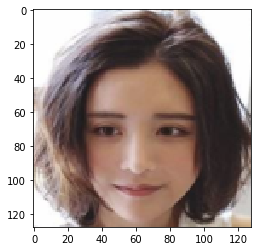

In [52]:
plt.imshow(np.transpose(a.cpu()[0], (1, 2, 0)))

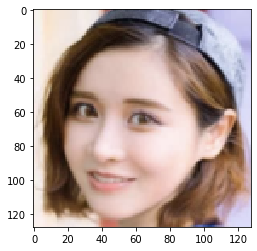

In [53]:
plt.imshow(np.transpose(p.cpu()[0], (1, 2, 0)))

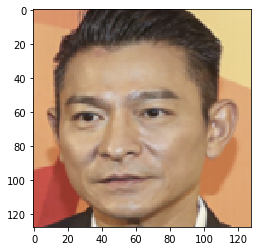

In [54]:
plt.imshow(np.transpose(n.cpu()[0], (1, 2, 0)))

In [58]:
x = iter([1, 2])

In [62]:
next(x)

StopIteration: 